Here we'll try to make ViT-Base transformer from **An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**. Here we will use the already created function to try to smooth the process of replicating this paper.  

In [ ]:
# Here we need latest version of torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 2.0"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.14+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

In [57]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Here we will use the module written as .py file to help us smoothen the process. module help us use dataloaders and ploting.
# also training and testing and plotting are written on that module.
try:
    from setup_plot import *
    from train_test_save import *
except:
    print(f"couldn't find the above mentioned modules. Kindly upload")

In [3]:
# Making the code device agnostic. Using GPU is recomanded.


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!!nvidia-smi -L

['GPU 0: Tesla T4 (UUID: GPU-f3353a35-fdff-d6c6-6094-ccdc8e06c155)']

### 1. The Data
Here we will use the the FoodVisionMini dataset, which is pizza, steak and sushi
image dataset. Here we will be using a light dataset to perform and see if we can replicate the paper where this new techinique first came to the whole world.

We'll upload the data from local drive and unzip it. It contains train and test folder with respective images.

In [ ]:
!unzip data.zip  # unzippin the data

In [5]:
from torch import nn
from torchvision import transforms
from pathlib import Path

img_path = Path("data/")  # defining the path for images

In [6]:
img_path# Setup directory paths to train and test images
train_dir = img_path / "pizza_steak_sushi/train"
test_dir = img_path/ "pizza_steak_sushi/test"

### 2. Create Datasets and Dataloaders
As we've got our data and setup the directories for each. Now we'll use the setup_dataloaders() function in setup_plot.py
First we'll create a transform to perpare our images.

That's where our first references to ViT paper will come, where in table 3 it was mentioned that training resolution is 224X224.


Creating transforms


In [7]:
 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### Turn images in dataloader's
Transforms are created. Now's let's create our data loader's. 
we use batch size 32 is good for the needs to fit into the GPU memory at a time.


In [9]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff5f26f6470>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize the image
As we've loaded our data now is the time to visualize the images to see how they look.
So, let's get a single image and label from a batch of data and inspect their shapes.

In [10]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]  # Get a single image from the batch

image.shape, label # View the batch shapes

(torch.Size([3, 224, 224]), tensor(0))

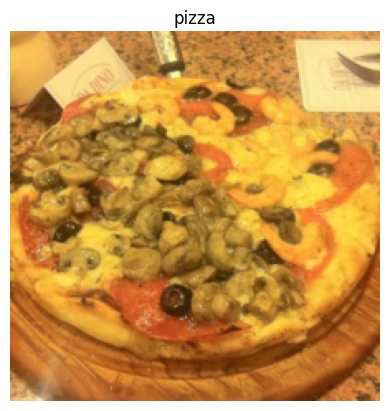

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearranging according to matplotlib [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 3. Starting with Vit-base: an overview
Here we're trying to replicate the ViT-Base for our problem FoodVisionMini dataset.

so our model inputs are: images of pizza, steak and sushi.




### Getting specific about the paper.
What will we use and how will we perform the implementation.
- 1. **Figure1** - The overview of the model in graphical sense. It is self explanatory and we can creat whole architecture from that alone.
- 2. **section3.1** - Mathematical equations for more insights
-3. **Table1** - This table shows various hyperparameter setting. For now're focused on the ViT-base.

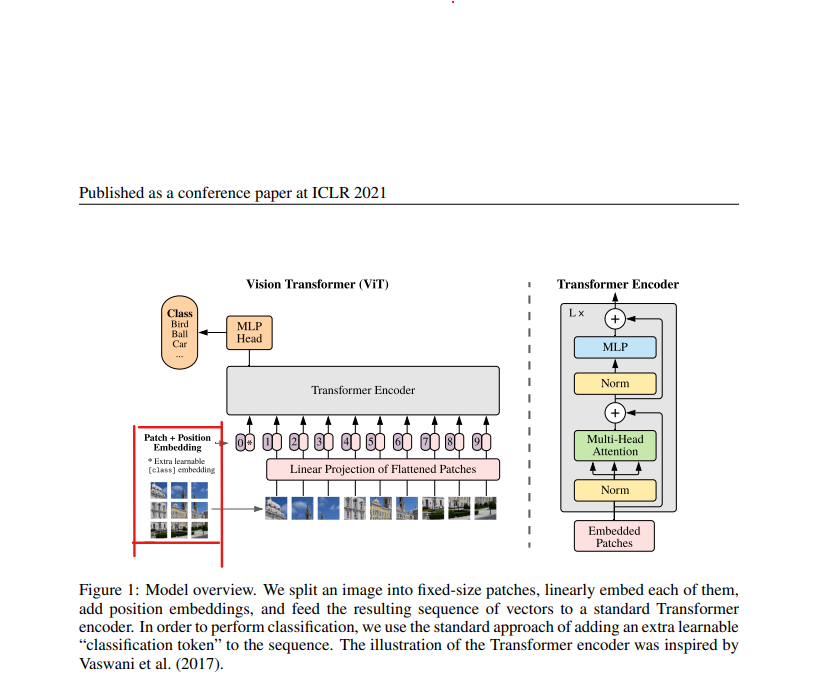

The main equations

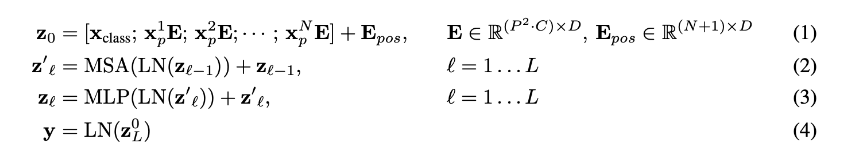

Here is the table 1

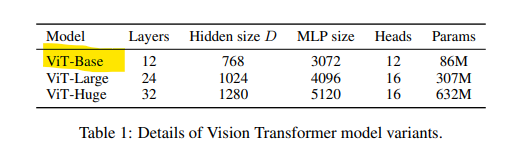

### 4. Split data into patches and create embedding
We will create embedding of patches it will represent the data in a good learnable way, chances are the learning algorithms will perform well on them.

In [12]:
# Create example values
height = 224 # H 
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [13]:
embedding_layer_input_shape = (height, width, color_channels)  # input shape


embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)  # Output shape

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning a single image into patches
So as know now the ideal input and output shapes for out **patch embedding** layer, let's move towards making it.
Let's turn our single image into patches

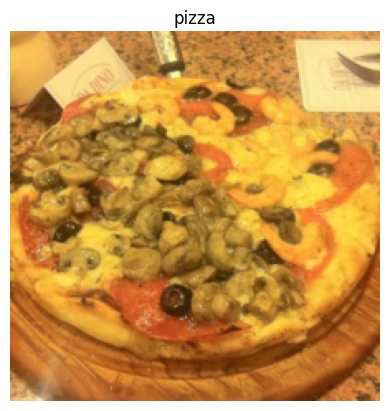

In [14]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

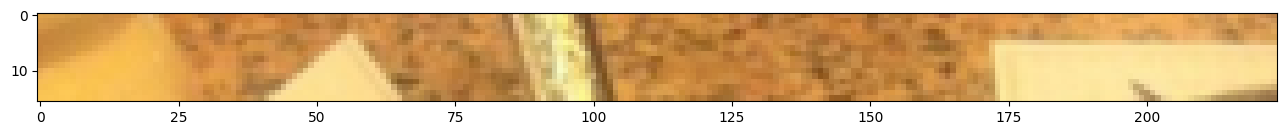

In [15]:
 
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Turning the top row into patches.

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


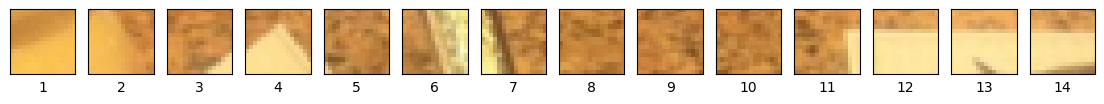

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# iterate through all
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

This looks good let's iterate it over through the whole image.


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


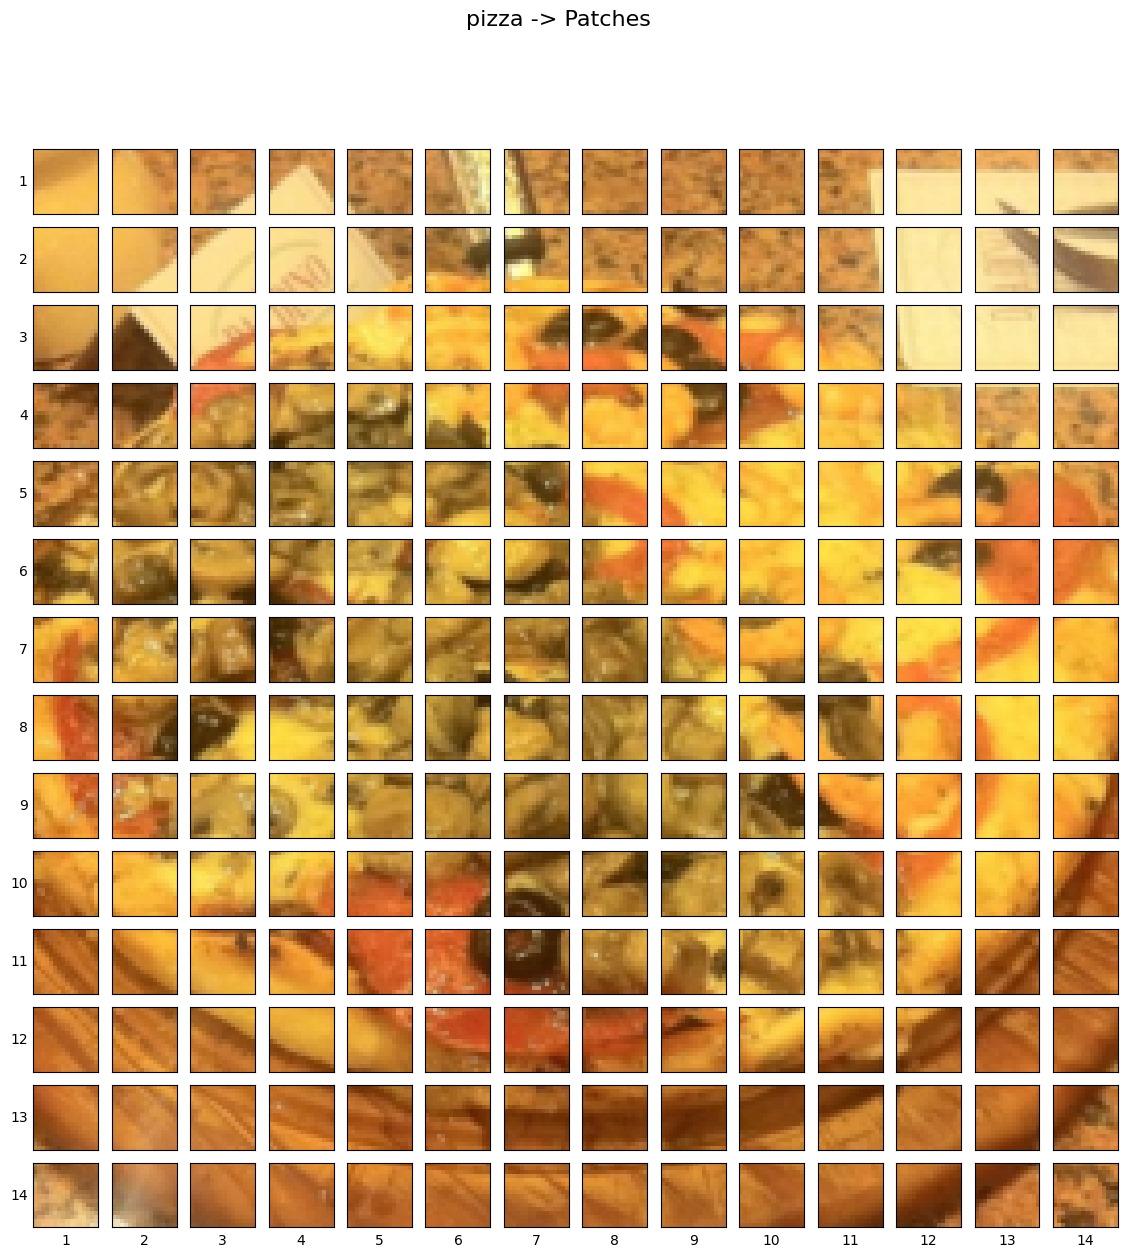

In [17]:

img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


fig.suptitle(f"{class_names[label]} -> Patches", fontsize=16)
plt.show()

This is just for demonstation here we'll creates patches with convolution.

Now we have to turn each of these patches into embeddings and covert them into a sequence for that we'll use PyTorch layers.
We'll use **torch.nn.Conv2d()**.\
By setting the **kernel_size** and **stride** parameter of Conv2d layer equal to 16 , we can effectively get layer that splits our images into patches and create a learnable embedding.\
As we know:\
**Input**: 2D image with size **H x W x C**.
**Output**: The image gets converted to a sequence of flattened 2D patches with size **N x (Psquared.C)**.




In [18]:
from torch import nn

# Set the patch size
patch_size=16

conv2d = nn.Conv2d(in_channels=3, # color channels
                   out_channels=768, # D: this is the embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

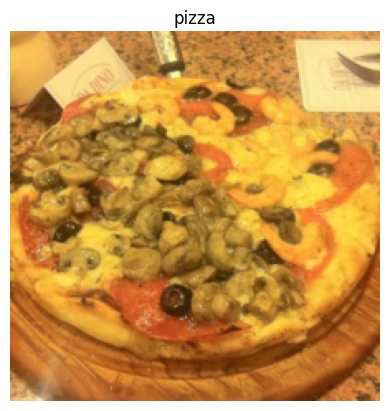

In [19]:

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional layer 
image_conv = conv2d(image.unsqueeze(0)) # dimension should be (batch, height, width, color_channels)
print(image_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through conv layer turns it into the series of 768(embedding size D) feature maps.

Let's visualize 5 random features maps and what they looks like.

Showing random convolutional feature maps from indexes: [461, 671, 685, 590, 136]


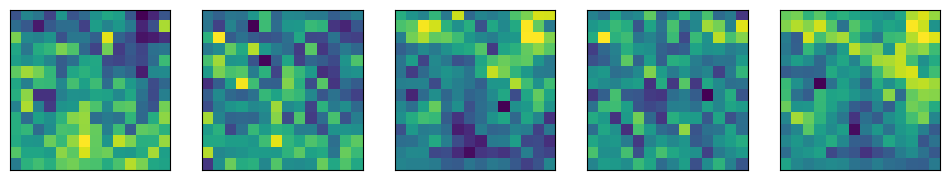

In [21]:
# Plot random 5 convolutional feature maps
import random
random_index = random.sample(range(0, 758), k=5) # picking 5 random indexes
print(f"Showing random convolutional feature maps from indexes: {random_index}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_index):
    image_conv_feature_map = image_conv[:, idx, :, :] # output tensor index
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

These features maps seems to represent the original image.
These features may change over times as NN learns.
Because of this, these features maps can be considered a **learnable embedding** of our image.


In [ ]:
# # Get a single feature map in tensor form
# single_feature_map = image_out_of_conv[:, 0, :, :]
# single_feature_map, single_feature_map.requires_grad

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Flattening the patch embedding but they still are in 2D. we need 1D sequence of patch embedding let's use torch.nn.Flatten

In [23]:
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image  shape: torch.Size([1, 768, 196])


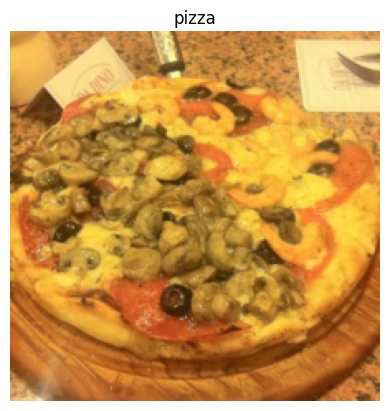

In [24]:

plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_conv_output = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_conv_output.shape}")

# Flatten the feature maps
conv_flattened = flatten_layer(image_conv_output)
print(f"Flattened image  shape: {conv_flattened.shape}")

In [25]:
conv_flattened_reshaped = conv_flattened.permute(0, 2, 1) 
print(f"Patch embedding sequence shape: {conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


let's visualize one of feature maps with 1D flattened sequence


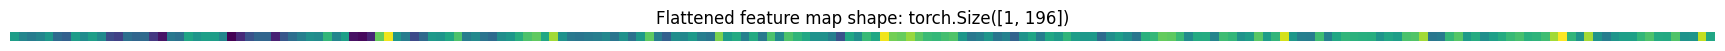

In [26]:
# (batch_size, number_of_patches, embedding_dimension)
single_flattened_feature_map = conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.1971, -0.2519, -0.2751, -0.2537, -0.2110, -0.3149, -0.3357, -0.1994,
          -0.2362, -0.1942, -0.2404, -0.3797, -0.4030, -0.3062, -0.3274, -0.3168,
          -0.4179, -0.4814, -0.2863, -0.3014, -0.1787, -0.2171, -0.1933, -0.1982,
          -0.2534, -0.5120, -0.4451, -0.3679, -0.3270, -0.3265, -0.4585, -0.3596,
          -0.3068, -0.2680, -0.2292, -0.2387, -0.1380, -0.2549, -0.1937, -0.4876,
          -0.4970, -0.4528, -0.0778,  0.0411, -0.2143, -0.2738, -0.3857, -0.3180,
          -0.2064, -0.2181, -0.1753, -0.1054, -0.2745, -0.2456, -0.2944, -0.3150,
          -0.2325, -0.2135, -0.1568, -0.1050, -0.0844, -0.1750, -0.0242, -0.2235,
          -0.2839, -0.2912, -0.2782, -0.2700, -0.2508, -0.2925, -0.2271, -0.2978,
          -0.2071, -0.0859, -0.2734, -0.3389, -0.2350, -0.2493, -0.2089, -0.2712,
          -0.2893, -0.0583, -0.1995, -0.1664, -0.2668, -0.1669, -0.2809, -0.1065,
          -0.2411, -0.1051, -0.1427, -0.1740, -0.2246, -0.2252, -0.2683, -0.3687,
          -0.175

### Turning ViT patch embedding into a PyTorch Module
We can do so by subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.

In [28]:

class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    """ 
    # Initialize with variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # layer to turn in patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, 
                                  end_dim=3)
 
    def forward(self, x):
        # assertion to check if inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size and patch size should be divisible, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)  
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension

Trying above class on a single image


In [29]:
torch.cuda.manual_seed(42)

patch = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patch(image.unsqueeze(0)) # add an extra batch dimension on the 0th index
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


That worked great, our input and output shape matches with what is mentioned in paper.
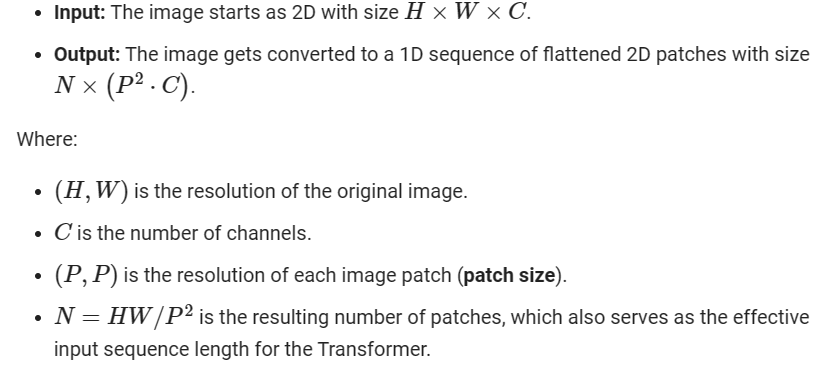

In [30]:
rand_image = (1, 3, 224, 224)  # random input size

# Get a summary of the input and outputs of PatchEmbedding
summary(PatchEmbedding(), 
        input_size=rand_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.3889, -0.1354,  0.2645,  ...,  0.0810,  0.1065, -0.3518],
         [ 0.2698, -0.1016,  0.2224,  ...,  0.0502,  0.1399, -0.4568],
         [ 0.3021, -0.1608,  0.3162,  ...,  0.0426,  0.1683, -0.4017],
         ...,
         [ 0.1240, -0.1039,  0.1694,  ..., -0.0248,  0.2083, -0.3508],
         [ 0.3399, -0.1013,  0.2110,  ...,  0.0579, -0.0509, -0.1564],
         [ 0.3215, -0.1227,  0.1935,  ...,  0.0863,  0.1224, -0.3286]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Class token embedding
Now, we have to create a class token embedding which is a learnable embedding and we need to "preprend a learnable embedding to the sequence of embedded patches".

In [32]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # embedding is learnable
print(class_token[:, :, :10]) 

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")  # class token shape

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [33]:
# Adding cls embedding in front of
patch_embeddedimage_with_classembedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embeddedimage_with_classembedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embeddedimage_with_classembedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.3889, -0.1354,  0.2645,  ...,  0.0810,  0.1065, -0.3518],
         [ 0.2698, -0.1016,  0.2224,  ...,  0.0502,  0.1399, -0.4568],
         ...,
         [ 0.1240, -0.1039,  0.1694,  ..., -0.0248,  0.2083, -0.3508],
         [ 0.3399, -0.1013,  0.2110,  ...,  0.0579, -0.0509, -0.1564],
         [ 0.3215, -0.1227,  0.1935,  ...,  0.0863,  0.1224, -0.3286]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [41]:
# view the patch embedding img with class embeding
patch_embeddedimage_with_classembedding, patch_embeddedimage_with_classembedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.2745, -0.1382,  0.0344,  ..., -0.0748, -0.1448,  0.1859],
          [ 0.2927, -0.1342,  0.0439,  ..., -0.0608, -0.1587,  0.2164],
          ...,
          [ 0.2981, -0.1501,  0.0266,  ..., -0.0160, -0.1422,  0.2750],
          [ 0.3917, -0.2158,  0.0355,  ...,  0.0297, -0.1481,  0.3296],
          [ 0.6282, -0.3290,  0.0114,  ..., -0.0469, -0.2221,  0.4472]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

### Positional embeddings
Position embeddings are added to the patch embeddings to retain positional information. 

our current embedding are of shape([1, 197, 768])

Equation from paper states position embeddings should have the shape:
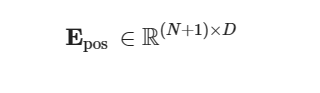

In [34]:
num_of_patches = int((height * width) / patch_size**2)
# Get embedding dimension
embedding_dim = patch_embeddedimage_with_classembedding.shape[2]

# learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             num_of_patches+1, 
                                             embedding_dim),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Postional embeddings created, let's add them to our sequence of patch embeddings with a prepend class token.

In [35]:
# Add the position embedding to the patch and class token embedding
patch_pos_embedding = patch_embeddedimage_with_classembedding + position_embedding
print(patch_pos_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_pos_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3889, 0.8646, 1.2645,  ..., 1.0810, 1.1065, 0.6482],
         [1.2698, 0.8984, 1.2224,  ..., 1.0502, 1.1399, 0.5432],
         ...,
         [1.1240, 0.8961, 1.1694,  ..., 0.9752, 1.2083, 0.6492],
         [1.3399, 0.8987, 1.2110,  ..., 1.0579, 0.9491, 0.8436],
         [1.3215, 0.8773, 1.1935,  ..., 1.0863, 1.1224, 0.6714]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Putting it together from image to embedding

In [36]:
torch.cuda.manual_seed(42)


patch_size = 16

# getting the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Getting image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Creating patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)
# passing input
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# creating cls token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Cls token embedding shape: {class_token.shape}")

# Prepend cls token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with cls token shape: {patch_embedding_class_token.shape}")

# Creating pos embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Adding pos embedding to patch embedding with cls token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Cls token embedding shape: torch.Size([1, 1, 768])
Patch embedding with cls token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### 5. Multi-Head-Attention(MSA)
Now, let's move on to the next part of ViT architecture.

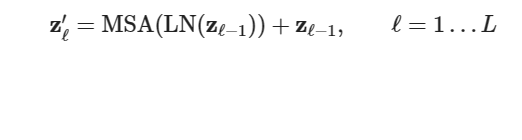

This equation indicate MSA layer wrapped in LayerNorm(LN) with a residual connection

**LayerNorm(LN)** **Layer**
layer normalization (torch.nn.LayerNorm()) normalized an input over the last dimension. Its main parameter is normalized_shape which can be set in our case to Dimension size 768.\
LN help improves the training and model generalization.

**Multi-Head** **Self Attention(MSA)** **layer**

This was originally designed for text inputs. original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.\
Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

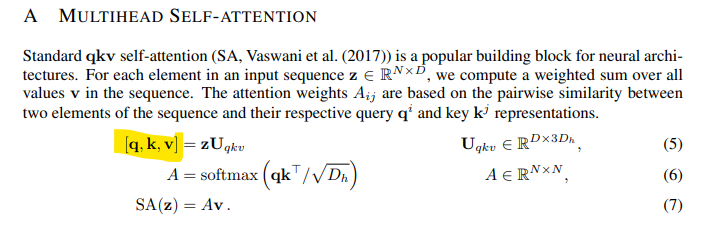

Teh image above highlists the triple embedding input to the MSA layer.

This is knows as **query**, **key**, **value** input or **qkv** for short.
In our case triple embedding ipupt will be three versions of the output of LN.

In [37]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # Initialize the hyperparameters
    def __init__(self,
                 embedding_dim:int=768, #D
                 num_heads:int=12, # Heads as per vit_base
                 attn_dropout:float=0): 
        super().__init__()
        
        #  Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False)
        return attn_output

MSA block is created let's try it out on the instance of multiheadattentionblock and passing through the patch_and_position_embedding.

In [38]:
# instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, 
                                                             num_heads=12) 

# Pass image embedding(patch+pos) through msahead
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Multilayer perceptron(MLP)
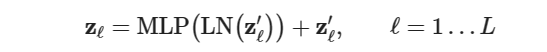

Here MLP is multilayer perceptron and LN is layer normalization.

In paper the structure is **MLP** contains 2 layers with **GELU** non-linearity.


In [39]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        #  Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU "
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim),
            nn.Dropout(p=dropout) # "Dropoutis applied after every dense layer.."
        )
    
    # Creating a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's try it out on the an example


In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,  
                     mlp_size=3072, 
                     dropout=0.1) 

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Transformer Encoder
Now let's create the transformer encoder by stacking MultiheadSelfAttentionBlock and MLPblock together.\
in DL encoder/auto-encoder generally referes to a stack of layers that encodes and input (turns it into some form of numerical information).


In [41]:

class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # Initialize the class with ViT-base hyperparameters
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D
                 num_heads:int=12, # Heads Vit-base
                 mlp_size:int=3072, # MLP size ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout(dense layers)
                 attn_dropout:float=0): # Amount of dropout(attention layers)
        super().__init__()

        # Create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # Create MLP block
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    #  forward() method  
    def forward(self, x):
        
        # Create residual connection for MSA block
        x =  self.msa_block(x) + x  #  add the input to the output
        
        # 7. Create residual connection for MLP block 
        x = self.mlp_block(x) + x  # add the input to the output
        
        return x

For our case as given int the picture we've to stack L times the number of encoder blocks. for our particular case ViT-base we will stack 12 transformer encoder block together.
Let's have a look at the summary of our transfoerm encoder

In [42]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 8. Finally ViT
Finally putting it all toghether to create ViT
We will combine all the block we've created to replicate the full ViT architecture. From patch and positional encoding to transformer encoder to MLP head.


In [43]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # Initialize the class with hyperparameters of Vit-Base
    def __init__(self,
                 img_size:int=224, # Training resolution
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1,  
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet1k but can customize this
        super().__init__()
        # asserting to be compatible size
        assert img_size % patch_size == 0, f"Size should be compatible: {img_size}, patch size: {patch_size}."
        
        # Calculate number of patches
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        #  Creating learnable class embedding 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Creating learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Creating embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Creating patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # Create a forward() method
    def forward(self, x):
        
        # Get batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding 
        x = self.position_embedding + x

        # Run embedding dropout
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [44]:
# Example of above
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension"

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [45]:
torch.cuda.manual_seed(42)

# Creating a random tensor
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Creating an instance of ViT with the 3 classes
vit = ViT(num_classes=len(class_names))

# Passing the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.1341,  0.3817, -0.4598]], grad_fn=<AddmmBackward0>)

In [54]:
from torchinfo import summary

# # Print a summary of our ViTbase model
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### 9. Training
Now the time has come to train our model.

**optimizer** Adam - torch.optim.Adam()
**loss function** - Crossentroyploss(torch.nn.CrossEntropyLoss()) as it is a multiclass problem.

In [46]:
# Setup the optimizer to optimize our ViT model parameters
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999),  # same values as the paper
                             weight_decay=0.3)  # same values as the paper

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


torch.cuda.manual_seed(42)

# Train the model for 30 epochs and save results to dict
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                
                loss_fn=loss_fn,
                epochs=30,
                device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7480 | train_acc: 0.4102 | test_loss: 1.5348 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.2626 | train_acc: 0.4297 | test_loss: 2.6298 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.3507 | train_acc: 0.2773 | test_loss: 1.3039 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1268 | train_acc: 0.3984 | test_loss: 1.5322 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1382 | train_acc: 0.4219 | test_loss: 1.3998 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1213 | train_acc: 0.4141 | test_loss: 1.0202 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2121 | train_acc: 0.2852 | test_loss: 1.6472 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2547 | train_acc: 0.4297 | test_loss: 1.0122 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2827 | train_acc: 0.2812 | test_loss: 1.5447 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.3592 | train_acc: 0.2969 | test_loss: 1.0346 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.3001 | train_acc: 0.2812 | test_loss: 1.2269 | test_acc: 0.1979
Epoch: 12 | train_l

As can be seen above from the results our results are not satisfactory and good enough One reason could be that we used the base ViT which is about 85million parameters and our dataset is comparatively smaller. Also batch size differs substatially(32 used).

Let's see our loss curves.

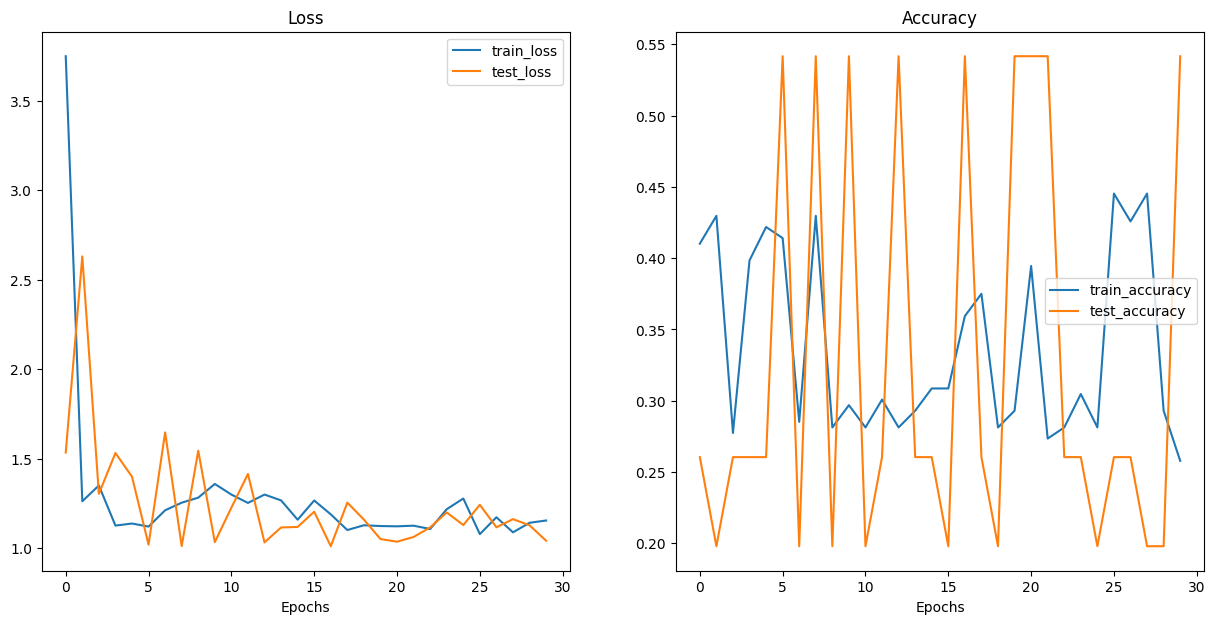

In [48]:
plot_loss_curves(results)

Seems like our model is all over the place. It is because of the data we have and the structure of our ViT.


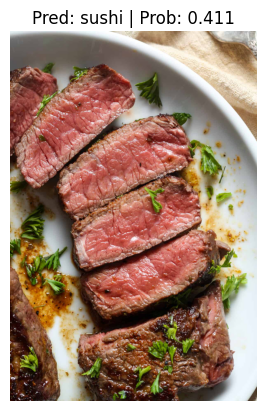

In [51]:
# prediction
path = "/content/data/random images/steak3.jpeg"
pred_and_plot_image(model=vit,
                    image_path=path,
                    class_names=class_names)

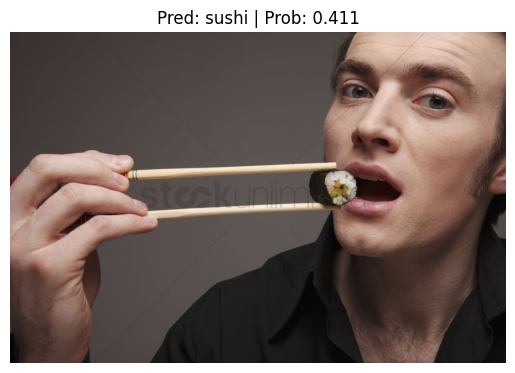

In [53]:
path = "/content/data/random images/man-eating-sushi-with-chopsticks_1848746.jpg"
pred_and_plot_image(model=vit,
                    image_path=path,
                    class_names=class_names)

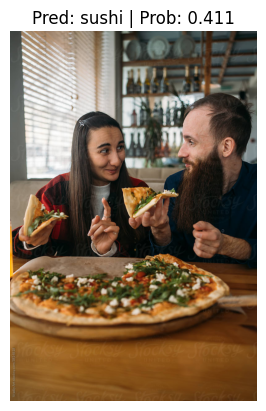

In [54]:
path = "/content/data/random images/pizza.jpg"
pred_and_plot_image(model=vit,
                    image_path=path,
                    class_names=class_names)

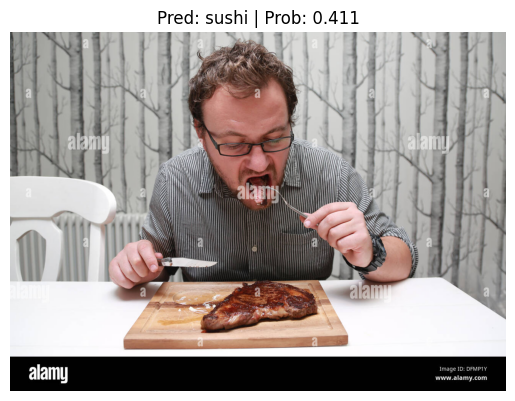

In [56]:
# Setup custom image path
custom_image_path = "/content/data/random images/steak2.jpg"

# Predict on custom image
pred_and_plot_image(model = vit,
                    image_path=custom_image_path,
                    class_names=class_names)

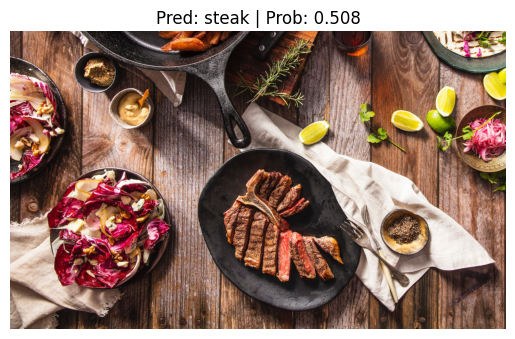

In [64]:
custom_image_path = "/content/data/random images/steakmultiple.jpg"

# Predict on custom image
pred_and_plot_image(model = vit,
                    image_path=custom_image_path,
                    class_names=class_names)

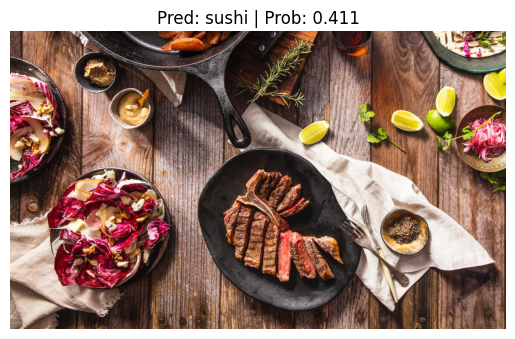

In [55]:
custom_image_path = "/content/data/random images/steakmultiple.jpg"

# Predict on custom image
pred_and_plot_image(model = vit,
                    image_path=custom_image_path,
                    class_names=class_names)

### pretrained ViT
Now, let's see we can improve our results or not. For that we've to use a pretrained model from *torchvision.models* on same dataset.\
One reason to use that is we've small dataset and limited computing resources, Better results in the paper is found maybe because of the larged computing resources and the datasets used by the researchers.

In [59]:
# The following requires torch latest version
import torch
import torchvision
from torch import nn

2.0.0+cu118
0.15.1+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Finally we will get Pretrained ViT-Base with patch size 16 from torchvision.models and prepare it for foodvisionmini use case by turning it feature extractor transfer learning model.

Here specifically we will:
- Getting the pretrained weights for Vit-Base trained on ImageNet-1k.
- Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
- Freeze all the parameters in ViT base model created to prevent the learning bu putting require_grad as False.
- Update the classifier head of the ViT model to suit our classes needs which is 3 in our case.   

In [62]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT #"DEFAULT" means best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)  # sending it to the GPU

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head
torch.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 96.4MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [65]:
# Get automatic transforms from pretrained ViT weights
pretrained_transforms = pretrained_vit_weights.transforms()
print(pretrained_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [66]:
# Setup dataloaders
train_dl_pretrained, test_dl_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=32) 


In [67]:
# Print a summary using torchinfo
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [68]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
torch.manual_seed(42)
pretrained_vit_results = train(model=pretrained_vit,
                               train_dataloader=train_dl_pretrained,
                               test_dataloader=test_dl_pretrained,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=20,
                               device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176
Epoch: 11 | train_loss: 0.0623 | train_acc: 0.9922 | test_loss: 0.1846 | test_acc: 0.9176
Epoch: 12 | train_l

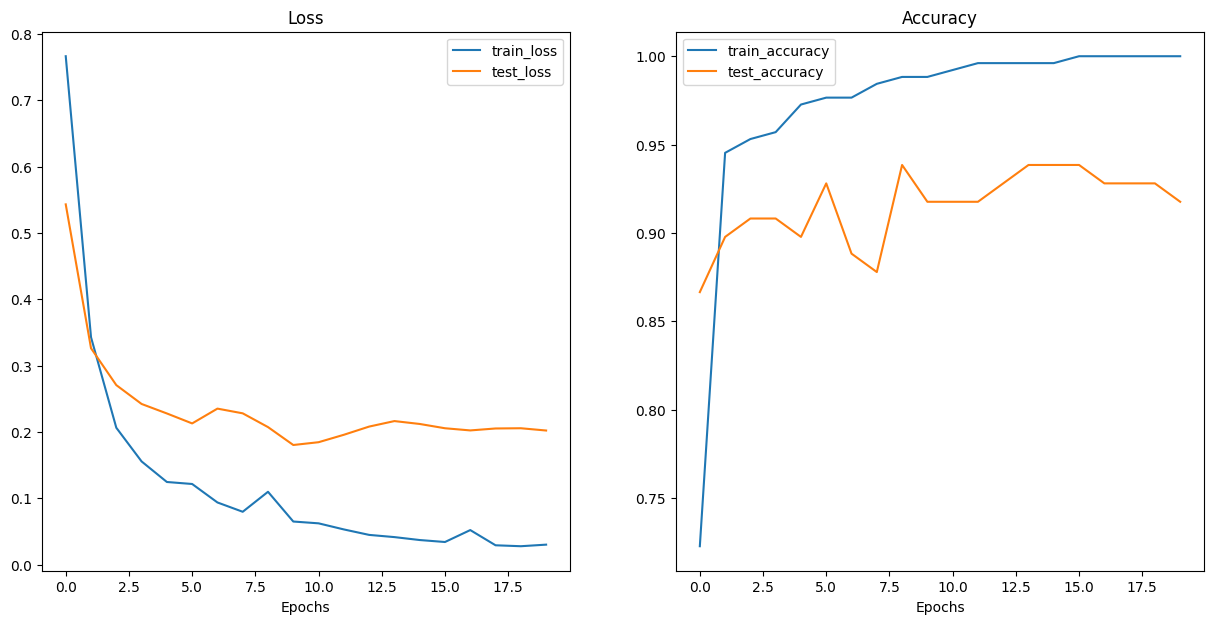

In [69]:
# Plot the loss curves

plot_loss_curves(pretrained_vit_results) 

saving the model

In [70]:
# Save the model

save_model(model=pretrained_vit,
           target_dir="models",
           model_name="pretrained_model_data.pth.pth")

[INFO] Saving model to: models/pretrained_model_data.pth.pth


knowing the size


In [74]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_model_size = Path("models/pretrained_model_data.pth.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 9 Predicting of Random Images

Here are some example of our model on some images taken on random.

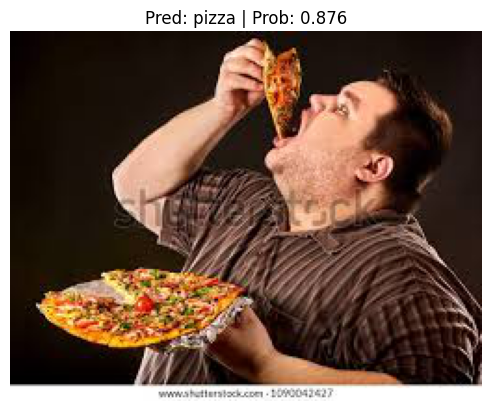

In [75]:
import requests

# Setup custom image path
custom_image_path = "/content/data/random images/pizza.jfif"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

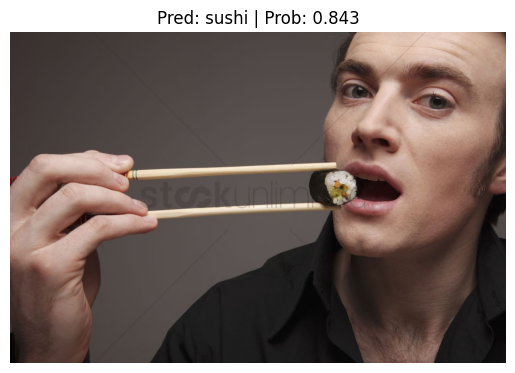

In [ ]:
path = "/content/data/random images/man-eating-sushi-with-chopsticks_1848746.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

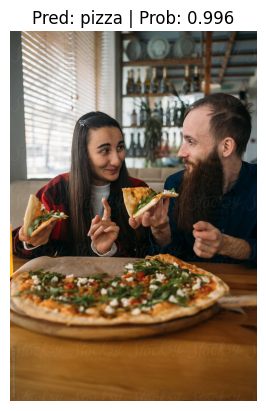

In [ ]:
path = "/content/data/random images/pizza.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

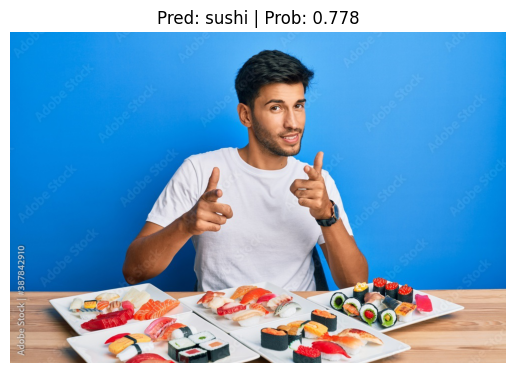

In [ ]:
path = "/content/data/random images/sushi.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

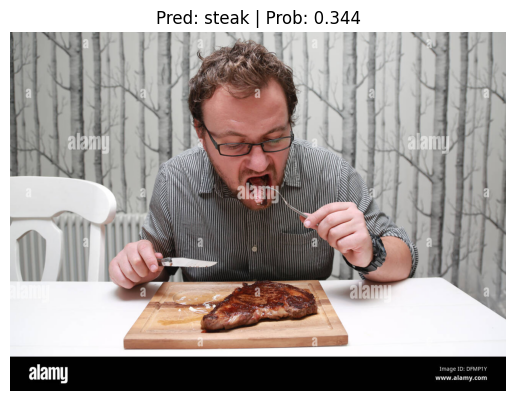

In [ ]:
path = "/content/data/random images/steak2.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

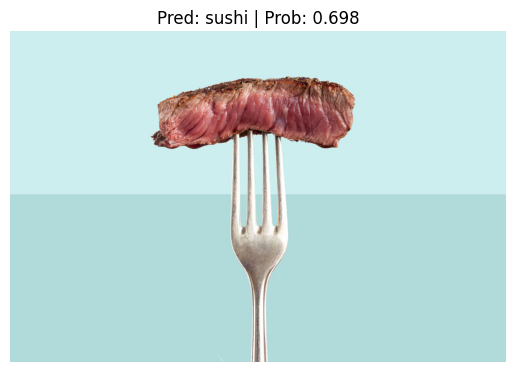

In [ ]:
path = "/content/data/random images/piecesteak.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

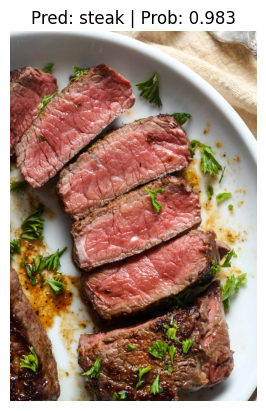

In [ ]:
path = "/content/data/random images/steak3.jpeg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

Seems like our model is preforming well with pretrained model it has some problem predicting the steak maybe because it cannot see inside 

## EfficinetB0(CNN pretrained model)
*torchvision.models.efficient_b0():\
Here we're going to create a pretrained EfficientNet_B0 model from torchvision.models with the output layer adjusted for our use case of classifying pizza, steak and sushi images.

In [ ]:
import torchvision
from torchinfo import summary


In [ ]:
def create_effnetb0():
    # Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freezing layers
    for param in model.features.parameters():
        param.requires_grad = False

    torch.manual_seed(42)  # reproducibility

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=3)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [ ]:
effnetb0 = create_effnetb0()  # instantiating a model

[INFO] Created new effnetb0 model.


In [ ]:
effnet_results = train(model=effnetb0,  # training on the model
                      train_dataloader=train_dataloader,  # train dataloader
                      test_dataloader=test_dataloader,   # test dataloader
                      optimizer=torch.optim.Adam(params=effnetb0.parameters()),  # adam optimizer
                      loss_fn=nn.CrossEntropyLoss(),  # loss function as CrossEntroyLoss
                      epochs=20,  # number of epochs
                      device=device  # GPU/CPU
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3592 | train_acc: 0.8281 | test_loss: 0.3751 | test_acc: 0.9489
Epoch: 2 | train_loss: 0.3229 | train_acc: 0.9688 | test_loss: 0.3333 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.3475 | train_acc: 0.8398 | test_loss: 0.3172 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.3369 | train_acc: 0.8281 | test_loss: 0.3246 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.2624 | train_acc: 0.9766 | test_loss: 0.3231 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4038 | train_acc: 0.8477 | test_loss: 0.3731 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3106 | train_acc: 0.8594 | test_loss: 0.3058 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3201 | train_acc: 0.8477 | test_loss: 0.2995 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.2933 | train_acc: 0.9609 | test_loss: 0.3055 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.2748 | train_acc: 0.9648 | test_loss: 0.2972 | test_acc: 0.9072
Epoch: 11 | train_loss: 0.3955 | train_acc: 0.8164 | test_loss: 0.3042 | test_acc: 0.9072
Epoch: 12 | train_l

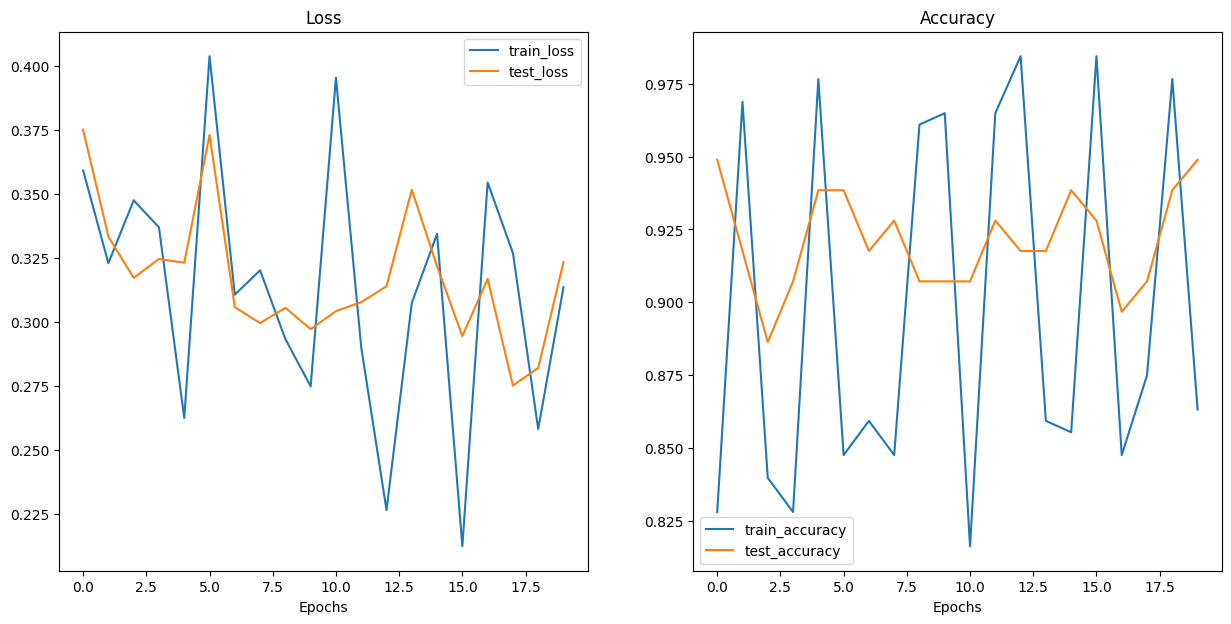

In [ ]:
plot_loss_curves(effnet_results) # Plotting of loss and Accuracy curves

## Conclusion
Here we tried make the base-ViT from [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929).
We went on with everything that was mentioned in paper(except for some) and replicated the ViT-Base model with 85 million parameter. Now we tested it on the little data we had which is foodvisionMini dataset. Our performances were not as good as it was on paper for that our explnation is that our architecture might be little bit differnt from what was implement in the paper(like the batch size, posionining of Norm layers etc). So we went on and use pretrained Vit-Base from torchvision.models and implement transfer learning and our results were good, we reached the test accuracy of 91 percent and our model is able to predict the food images fairly well. Only problem this is having is in predicting the **steak** in some images. But rest are fair enough. 
Then we tried using a pretrained light CNN model to have a prediction on it and we got fairly small difference only in CNN model the fluctuation of accuracy and losses were more significant. But overall accuracy came out to be same.
